In [2]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [3]:
def flip_bias_coin(n, p_heads=0.5):
    """
    Returns a vector of bools
    - True is a heads, false is a tails
    """
    return np.random.uniform(size=n) <= p_heads

Lets see an example of the bias coin at work

(array([ 18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  82.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

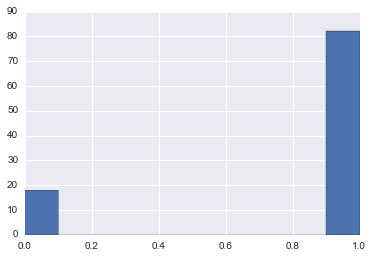

In [4]:
plt.hist(flip_bias_coin(100, p_heads=0.8))


This set of simulation will look at inferring if the coin is bias (of course we control how bias the coin is).

# Method 1: Chi Square Distribution

For a set of _n_ coin flips, we set our null hypothesis to be that the number of heads is approximately equal to the number of tails.

$$ \text{Null Hypothesis}: p_{head} = p_{tail} $$

$$ \text{Alt Hypothesis}: p_{head} \neq p_{tail} $$

For the proportion of number of heads, the sample statistic is normally distributed.

$$ X \sim N(np, np(1-p))$$

Which can be rewritten to be a standard normal distribution, $Z \sim N(0,1)$

$$ X = \sqrt{np(1-p)} Z + np $$
$$ Z = \frac{X  - np}{\sqrt{np(1-p)} } $$

Given _n_ total trials. 

The proportion of heads is given by:
$$ Z_{head} = \frac{X_{head} - np_{head}}{\sqrt{np_{head}(1-p_{head})} }$$

Similarily, the proportion of tails is:

$$ Z_{tail} = \frac{X_{tail} - np_{tail}}{\sqrt{np_{tail}(1-p_{tail})} }$$

The chi-squared distribution is then given as

$$ \chi^2_{1} \sim Z_{tail}^2  + Z_{head}^2 $$

To compute the chi distribution:

$$ \chi^2 = \frac{(O_{head} - E_{head})^2}{E_{head}} + \frac{(O_{tail} - E_{tail})^2}{E_{tail}}$$

From the computed chi2 stat, we can then compute the probability the observation could have occured given our null hypothesis. If the probability is less than a significant value, we say the observations is so rare we can reject the null hypothesis.

Lets simulate this!

In [5]:
from scipy.stats import chi2
from scipy.stats import chisquare
n = 95
def compute_sig_test(n, p_heads=0.5, verbose=False):
    trials = flip_bias_coin(n, p_heads=p_heads)
    obs_heads = sum(trials == True)
    obs_tails = sum(trials == False)
    exp_heads = n / 2
    exp_tails = n / 2
    T = (obs_heads - exp_heads)**2 / exp_heads + (obs_tails - exp_tails)**2 / exp_tails
    df = 1
    p_val = 1-chi2.cdf(T, df, loc=0, scale=1)
    if verbose:
        print T, p_val
    # same as computing it above but using the packaged software
    return chisquare(f_obs=[obs_heads, obs_tails], f_exp=[exp_heads, exp_tails])


In [6]:
bias = 0.5
n=50
print '(chi_stat, pvalue)=', compute_sig_test(n, p_heads=bias)

(chi_stat, pvalue)= (0.71999999999999997, 0.39614390915207409)


We can see that for a fair coin, the p-value is large enough we do not reject the null. 

In [7]:
bias = 0.8
n=50
print '(chi_stat, pvalue)=', compute_sig_test(n, p_heads=bias)

(chi_stat, pvalue)= (13.52, 0.00023603441652934905)


We can see that for a bias coin, the p-value is small enough we do reject the null. 

We can also see that the number of trials effects the outcome. Below shows what happens when you sweep the number of trials for a bias coin

In [8]:
pvals = []
n_trials_max=200
for n in range(2, n_trials_max):
    chis,p_val = compute_sig_test(n, p_heads=0.65)
    pvals.append(p_val)


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


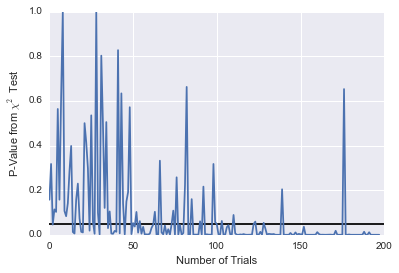

In [9]:
plt.plot(pvals)
plt.hlines(0.05, 0, n_trials_max)
plt.xlabel("Number of Trials")
plt.ylabel("P-Value from $\chi^2$ Test")

If there are not enough trials, the p-value is large enough that we cannot reject the null hypothesis even for a bias coin. However, with more trials, wee become more confident in rejecting the null hypothesis.

# Method 2: Maximum Likelihood Estimate

We can also model a single coin flip with the Bernoulli distribution. Assume each trial is independent of each other and the outcomes are either a success/heads ($X=1$) or a fail/tails ($X=0$).

Let the random variable $X$ represent the outcome of a single coin. Model the probability distribution of $P(X=x) = p^x(1-p)^{1-x}, x=[0,1]$ or $X ~ Be(p)$


For n independent Bernoulli trials, we say $X = (X_1, X_2,...X_n)$. The probability of $P(X)$ is simply the joint distribution of all the independent events.
$$ P(X)= P(X_1)*P(X_2)*...*P(X_n) = \prod^{n} p^x(1-p)^{1-x}$$
Say $P(X) = f(x|p)$

We want to then identify what value of $p$ will maximize the probability of the observed trials, hence the maximum likelihood estimate.

$$ \arg\max_p = f(x|p)  $$

This can be done by taking the derivative of the log-likelihood of $f$.

$$ l(x|p) = log(f(x|p)) = \sum^{n} xlog(p) + (1-x)log(1-p)   $$

$$ \frac{\delta l(x|p)}{\delta p} = 
    \sum^{n} \frac{ \delta  xlog(p) + (1-x)log(1-p) }{\delta p}   = 
    \sum^{n} \frac{x}{p} - \frac{1-x}{1-p}
$$

$$
  \sum^{n} \frac{x-xp - p + px}{p} = \sum^{n} \frac{x - p}{p} = 0
$$

$$ 
    \sum^{n}x = np
$$

$$
    \hat{p} = \frac{\sum^{n}x}{n}
 $$

So this is super straightforward! We just sum up the proportion of successes and divide by the number of trials.

In [21]:
p_heads=0.5
n = 1000
trials_fair = flip_bias_coin(n, p_heads=p_heads)
p_hat_fair = sum(trials_fair) / float(n)
print p_hat_fair

0.509


In [22]:
p_heads=0.6
n = 1000
trials_bias = flip_bias_coin(n, p_heads=p_heads)
p_hat_bias = sum(trials_bias) / float(n)
print p_hat_bias

0.61


We can demonstrate the probability computed by our estimates of $p$. 


$$  P(X|\hat{p}) = \prod^{n} \hat{p}^x(1-\hat{p})^{1-x} $$

In [12]:
def prob_x_p(trials, p):
    return np.prod(np.power(p, trials)*np.power(1-p, 1-trials))

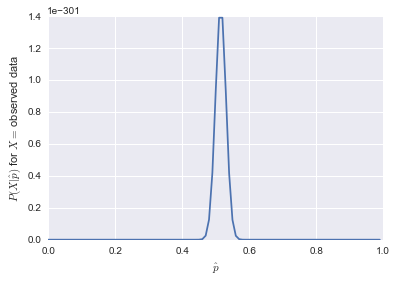

In [19]:
probs = []
x = np.arange(0,1, 0.01)
for i in x:
    probs.append(prob_x_p(trials_fair, i))
plt.plot(x,probs)
plt.xlabel('$\hat{p}$')
plt.ylabel("$P(X|\hat{p})$ for $X=$ observed data")

We can also see the standard error of our estimate. We know that the Bernoulli Model has a mean of $p$ and a variance of $p(1-p)=pq$. Recall that the standard error of a sample statistic is scaled by the number of samples.

$$ SE_{stat} = \frac{S_{stat}}{n} $$

Where $S_{stat}$ is the true statistic sample variance and $n$ is the number of samples. 

If $\hat{p}$ is the distribution mean, then the distribution's standard deviation is $\sqrt{\hat{p}(1-\hat{p})}$

The standard deviation of the statistic estimate is then computed to be 

$$ SE_{stat} = \frac{\sqrt{\hat{p}(1-\hat{p})}}{\sqrt{n}} $$

As a result, the confidence interval is simply

$$ \hat{p} \pm  z*\frac{\sqrt{\hat{p}(1-\hat{p})}}{\sqrt{n}}$$

We can therefore compute the confidence interval given our simulation.

In [37]:
import scipy
def compute_conf_interval(p_hat,n, conf= 0.05):

    z = scipy.stats.norm.ppf((1-conf))
    upper =  p_hat + z*np.sqrt(p_hat*(1-p_hat) / n)
    lower =  p_hat - z*np.sqrt(p_hat*(1-p_hat) / n)
    return (lower, p_hat, upper)

In [38]:
compute_conf_interval(p_hat_bias, n,)

(0.58462976571394543, 0.60999999999999999, 0.63537023428605455)

In [39]:
compute_conf_interval(p_hat_fair, n,)

(0.4829967941494886, 0.50900000000000001, 0.53500320585051142)

Clearly, more data provides better confidence (tighter intervals). Here is an example when $n$ is so small, the confidence is not very tight

In [46]:
p_heads=0.4
n = 10
trials_test = flip_bias_coin(n, p_heads=p_heads)
p_hat_test = sum(trials_test) / float(n)

compute_conf_interval(p_hat_test,n)

(0.2399258060622213, 0.5, 0.76007419393777864)

Above, we can see that we can't even clearly determine significant difference than a fair coin.